In [1]:
from functions import *
import math
import numpy as np
import torch as t
from torch import tensor
import scipy.constants as con
import matplotlib.pyplot as plt
import torch.linalg as ln
import scipy
import scipy.stats as stats
import variables as vr
from classes import *
from random import random



"""

The following code initializes the model with rubidium, certain transitions, some laserbeams, and a collision rule.

"""


#Rubidium Data
#
rubidium=species(
    con.atomic_mass*86.909180520,
    #defining energy levels should be expandable, need to dynamically assign energy levels (in terms of transitions and/or in terms of levels?)
    {
        "S12F1":0,
        "S12F2":4.5283e-24,
        "P12F0":2.54593588e-19,
        "P12F1":2.54593636e-19,
        "P12F2":2.545937398e-19,
        "P12F3":2.54593917e-19
    },
    87,
    1.5
)
    
    

#defining the transitions we care about (NEEDS to be declared before generating particles,
# transitions cared about tells which levels to generate for the particles)
#The branching ratios/ transition strenghts are currently added manually, in future these may be calculated procedurally.
Coolingbranrat=Tensor([
        [15,5,1,0,0,0,0],
        [0,10,8,3,0,0,0],
        [0,0,6,9,6,0,0],
        [0,0,0,3,8,10,0],
        [0,0,0,0,1,5,15]
    ]).to(vr.def_device)/15

D2repumpbranrat=Tensor([
        [6,3,1,0,0,],
        [0,3,4,3,0],
        [0,0,1,3,6]
    ]).to(vr.def_device)/12

D2offsetbranrat=Tensor([
        [4,2,0,0,0,],
        [2,1,3,0,0,],
        [0,3,0,3,0,],
        [0,0,3,1,2],
        [0,0,0,2,4]
    ]).to(vr.def_device)/12


#adds the relevant transitions to rubidium, and creates the rubidium level structure.
rubidium.D2cooling=Transition(38.11e6,"S12F2","P12F3",rubidium,Coolingbranrat)
rubidium.D2repump=Transition(38.11e6,"S12F1","P12F2",rubidium,D2repumpbranrat)
rubidium.D2offres=Transition(38.11e6,"S12F2","P12F2",rubidium,D2offsetbranrat)
rubidium.createstructure()

#[x,y,z]
#defining cooling lasers
Int=100
Cooling1=laserbeam([1,0,0],780e-9,cgaussianprofile(Int,0.01,0.02, vr.def_device),Cutoff=0.02,pol=[1,0,0])
Cooling2=laserbeam([-1,0,0],780e-9,cgaussianprofile(Int,0.01,0.02, vr.def_device),Cutoff=0.02,pol=[1,0,0])
Cooling3=laserbeam([0,1,0],780e-9,cgaussianprofile(Int,0.01,0.02, vr.def_device),Cutoff=0.02,pol=[0,0,1])
Cooling4=laserbeam([0,-1,0],780e-9,cgaussianprofile(Int,0.01,0.02, vr.def_device),Cutoff=0.02,pol=[0,0,1])
Cooling5=laserbeam([0,0,1],780e-9,cgaussianprofile(Int,0.01,0.02, vr.def_device),Cutoff=0.02,pol=[0,0,1])
Cooling6=laserbeam([0,0,-1],780e-9,cgaussianprofile(Int,0.01,0.02, vr.def_device),Cutoff=0.02,pol=[0,0,1])
Laserbeams=[Cooling1,Cooling2,Cooling3,Cooling4,Cooling5,Cooling6]

def AHh(x,A=0.0015):
    return (t.matmul(x,t.diag(tensor([A,A,-2*A],device=x.device,dtype=x.dtype))))

#Defines the environment simulated, which includes the Gas pressure, which laserbeams to include, Temperature, and magnetic field.
Env=Environment(3e-5 ,Laserbeams,300,B=AHh)



#need to sort out how to assign `rules` modularly, for now the following rule will create an infinite pyramid which will do.
# (return tensor of true/false depending on position)
def rule(x,def_device=vr.def_device):
    x,y,z=x[:,0],x[:,1],x[:,2]
    A=t.max(abs(x),abs(y))-z-0.1*t.ones(x.shape[0],device=def_device)
    A+=t.abs(A)
    A=t.ceil(A)
    A=(A==t.zeros(A.shape[0],device=A.device))
    #if given a tensor of positions, will return a tensor of bools for whether the rule is followed or not.
    return A

prub=particles(rubidium)




In [9]:
rubidium.lvlsize

20

In [7]:


#code demonstrating the retrieval of intensity from a laserbeam for given particle positions
positions=(1-2*t.zeros((10000,3)).uniform_())*0.1 #(random set of points)
I=Cooling1.intensity(positions)
print(t.max(I))



tensor(99.9350)


torch.Size([10000])

In [3]:
AHh(torch.ones((200,3)),1).shape

torch.Size([200, 3])

torch.Size([64, 3])
tensor([[ -32.9434,  -96.0546,  166.5029],
        [-519.5005,   -7.8755,  -84.9957],
        [-238.6821, -132.5480,  -58.4221],
        ...,
        [-160.4935, -161.9535, -247.6557],
        [-110.4795,   76.8900,  -29.8584],
        [ -89.9717,  129.6174, -333.5152]], dtype=torch.float64)


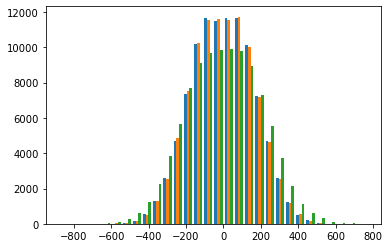

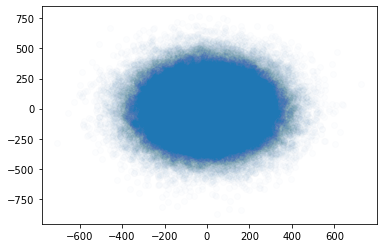

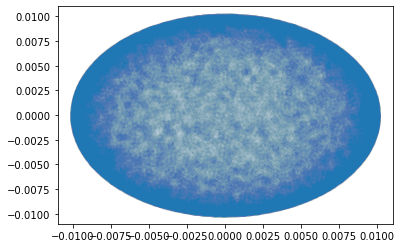

In [9]:
prub.createbyT(1)


prub.timestepadd(dt=0.000001,Tcutoff=1)
print(prub.x.shape)

prub.createbyT(100000)
print(prub.v)
plt.hist(prub.v.T,30)
plt.show()
plt.scatter(prub.v[:,1],prub.v[:,2],alpha=0.01)
plt.show()
plt.scatter(prub.x[:,1],prub.x[:,2],alpha=0.01)

#demonstrator code, showing the capacity of the particles class to generate new particles and their velocities/positions.


In [3]:
prub.createbyT(100)
eploc(prub.x,Env).size()



torch.Size([100, 6, 3, 1])

In [95]:
def forward(particles,Environment,dt=0.0000001):
    for p in particles:
        R=t.zeros((p.N,len(Environment.laserbeams),p.species.lvlsize,p.species.lvlsize),device=vr.def_device)
        for i in Environment.laserbeams:
            print(i.pol)
            

forward([prub],Env)

tensor([1, 0, 0])
tensor([1, 0, 0])
tensor([0, 0, 1])
tensor([0, 0, 1])
tensor([0, 0, 1])
tensor([0, 0, 1])


In [13]:
def transitionrate(Transitions,Environment,particles,device=vr.def_device):
    #input as above:
    # Transitions, an array of the transitions to include
    # Environment, the environment in which the transition rates are calculated 
    # particles, the particles (should be single species) which have their transition rates calculated. 
    #  
    #Output should be a set of matrices describing the transition rates for each transition, and/or a total transition rate matrix. (need to consider how to properly work this)

    for Transition in Transitions:
        Bdtun=Environment.B(particles.x)

In [4]:
vel=chi.rvs(4,size=N,scale=v_therm)*2/pi
v_thermcutoff=sqrt(2*conk*Tcutoff/self.species.mass)


NameError: name 'N' is not defined